In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from PIL import Image
from tqdm import tqdm

In [7]:
import os
import cv2
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import keras
from keras import layers
from keras.models import Model
# from keras.optimizers import Adam
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

In [9]:
import tensorflow as tf

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from collections import namedtuple
Label = namedtuple( 'Label' , ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'])

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]

In [12]:
mapping_20 = { 
        0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 8, 9: 1,
        10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3,
        20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7,
        30: 7, 31: 7, 32: 7, 33: 7, 34: 7
    }

In [13]:
width, height = 128, 128
IMAGE_SIZE = [width, height]
classes = 35
batch_size = 16
id2color = { label.id : np.asarray(label.color) for label in labels }

In [14]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array
    
    return image, mask
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category

In [15]:
# SPLIT VAL DATA INTO VAL AND TEST

train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

train_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/train/'
val_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/val/'
test_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/test/'
# os.makedirs(train_folder); os.makedirs(val_folder); 
os.makedirs(test_folder)

shutil.copytree(train_filepath, train_folder, copy_function = shutil.copy)
shutil.copytree(val_filepath, val_folder, copy_function = shutil.copy)

files = os.listdir(val_folder)
random_files = random.sample(files, 50)
for f in random_files:
  shutil.move(val_folder + f, test_folder + f)

In [16]:
# Store the images, the masks, and the encoded masks
train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []
test_images = []
test_masks = []
test_masks_enc = []

In [17]:
def build_data(folder, images, masks, masks_enc):
    for file in tqdm(os.listdir(folder)):
        image, mask = image_mask_split(folder + file, IMAGE_SIZE)
        images.append(image)
        masks.append(mask)
        masks_enc.append(find_closest_labels_vectorized(mask, id2color))
    return images, masks, masks_enc

In [18]:
print('building training dataset: ')
train_images, train_masks, train_masks_enc = build_data(train_folder, train_images, train_masks, train_masks_enc)
print('building validation dataset: ')
val_images, val_masks, val_masks_enc = build_data(val_folder, val_images, val_masks, val_masks_enc)
print('building testing dataset: ')
test_images, test_masks, test_masks_enc = build_data(test_folder, test_images, test_masks, test_masks_enc)

building training dataset: 


100%|██████████| 2975/2975 [02:18<00:00, 21.47it/s]


building validation dataset: 


100%|██████████| 450/450 [00:20<00:00, 21.48it/s]


building testing dataset: 


100%|██████████| 50/50 [00:02<00:00, 21.47it/s]


In [20]:
rand_images = val_images[0]
rand_masks = val_masks[0]
var = val_masks_enc[0]
crop_width = int(width/2); crop_height = int(height/2)
seed = (1,2)
rand_images = tf.image.stateless_random_crop(
                value = rand_images, 
                size = (crop_width, crop_height, 3), 
                seed = seed
#                 seed = 42
            )
rand_masks = tf.image.stateless_random_crop(
                value = rand_masks, 
                size = (crop_width, crop_height, 3), 
                seed = seed
#                 seed = 42
            )
rand_masks_enc = tf.image.stateless_random_crop(
                value = var.astype(float), 
                size = (crop_width, crop_height), 
                seed = seed
#                 seed = 42
            )
enc1 = var
tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
for row in range(enc.shape[0]):
    for col in range(enc.shape[1]):
        tmp[row, col, :] = id2color[enc[row, col]]
        tmp = tmp.astype('uint8')

enc2 = rand_masks_enc
tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
for row in range(enc.shape[0]):
    for col in range(enc.shape[1]):
        tmp[row, col, :] = id2color[enc[row, col]]
        tmp = tmp.astype('uint8')

plt.figure(figsize=[15, 10])
plt.subplot(2,4,1); plt.imshow(val_images[0])
plt.subplot(2,4,2); plt.imshow(val_masks[0])
plt.subplot(2,4,3); plt.imshow(val_masks_enc[0].astype(float))
plt.subplot(2,4,4); plt.imshow(tmp1)
plt.subplot(2,4,5); plt.imshow(rand_images)
plt.subplot(2,4,6); plt.imshow(rand_masks)
plt.subplot(2,4,7); plt.imshow(rand_masks_enc)
plt.subplot(2,4,8); plt.imshow(tmp2)


NameError: name 'enc' is not defined

In [21]:
# type(val_images[0])
# val_images[0]
# val_masks[0]
val_masks_enc[0]
var.astype(int).shape, val_images[0].shape

((128, 128), (128, 128, 3))

In [22]:
# type(val_masks_enc[0])
# val_masks_enc[0].shape
var = val_masks_enc[0]
var = var.astype(int)
encccc = tf.image.random_crop(
                value = var, 
                size = (crop_width, crop_height), 
#                 seed = seed
                seed = 42
            )

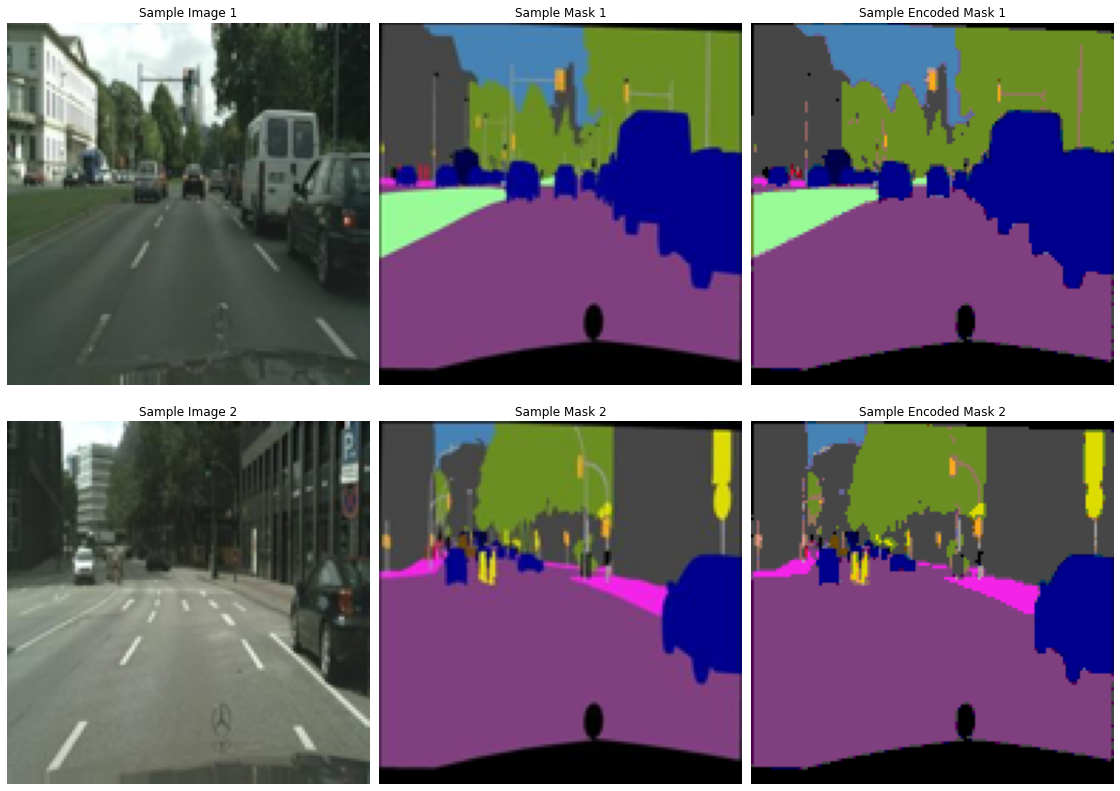

In [23]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [24]:
del train_masks, val_masks

In [25]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [26]:
def bottle_neck(inputs):
  res = inputs
  x = layers.Conv2D(64,kernel_size=1,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(64,kernel_size=3,padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  x3 = layers.Conv2D(128,kernel_size=1,padding='same')(x2)
  x3 = layers.BatchNormalization()(x3)
  x3 = tf.keras.activations.relu(x3)
  res = layers.Conv2D(128 , kernel_size =1 , padding = 'same')(res)
  output = x3+res
  output = tf.keras.activations.relu(output)
  return output 

def basic_block(inputs,num_channels,stride,padding):
  res = inputs

  x = layers.Conv2D(num_channels,kernel_size=3,strides=stride,padding = padding)(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  
  x2 = layers.Conv2D(num_channels,kernel_size=3,strides=1,padding = padding)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  return x2

In [27]:
input_shape = keras.Input(shape=(width, height, 3))

x1 = bottle_neck(input_shape)
output = layers.Conv2D(classes,1,1,padding='same')(x1)
print(output.shape)

(None, 128, 128, 35)


In [28]:
model = keras.Model(inputs=input_shape, outputs=output, name="HR-NET")
model.summary()

Model: "HR-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________________

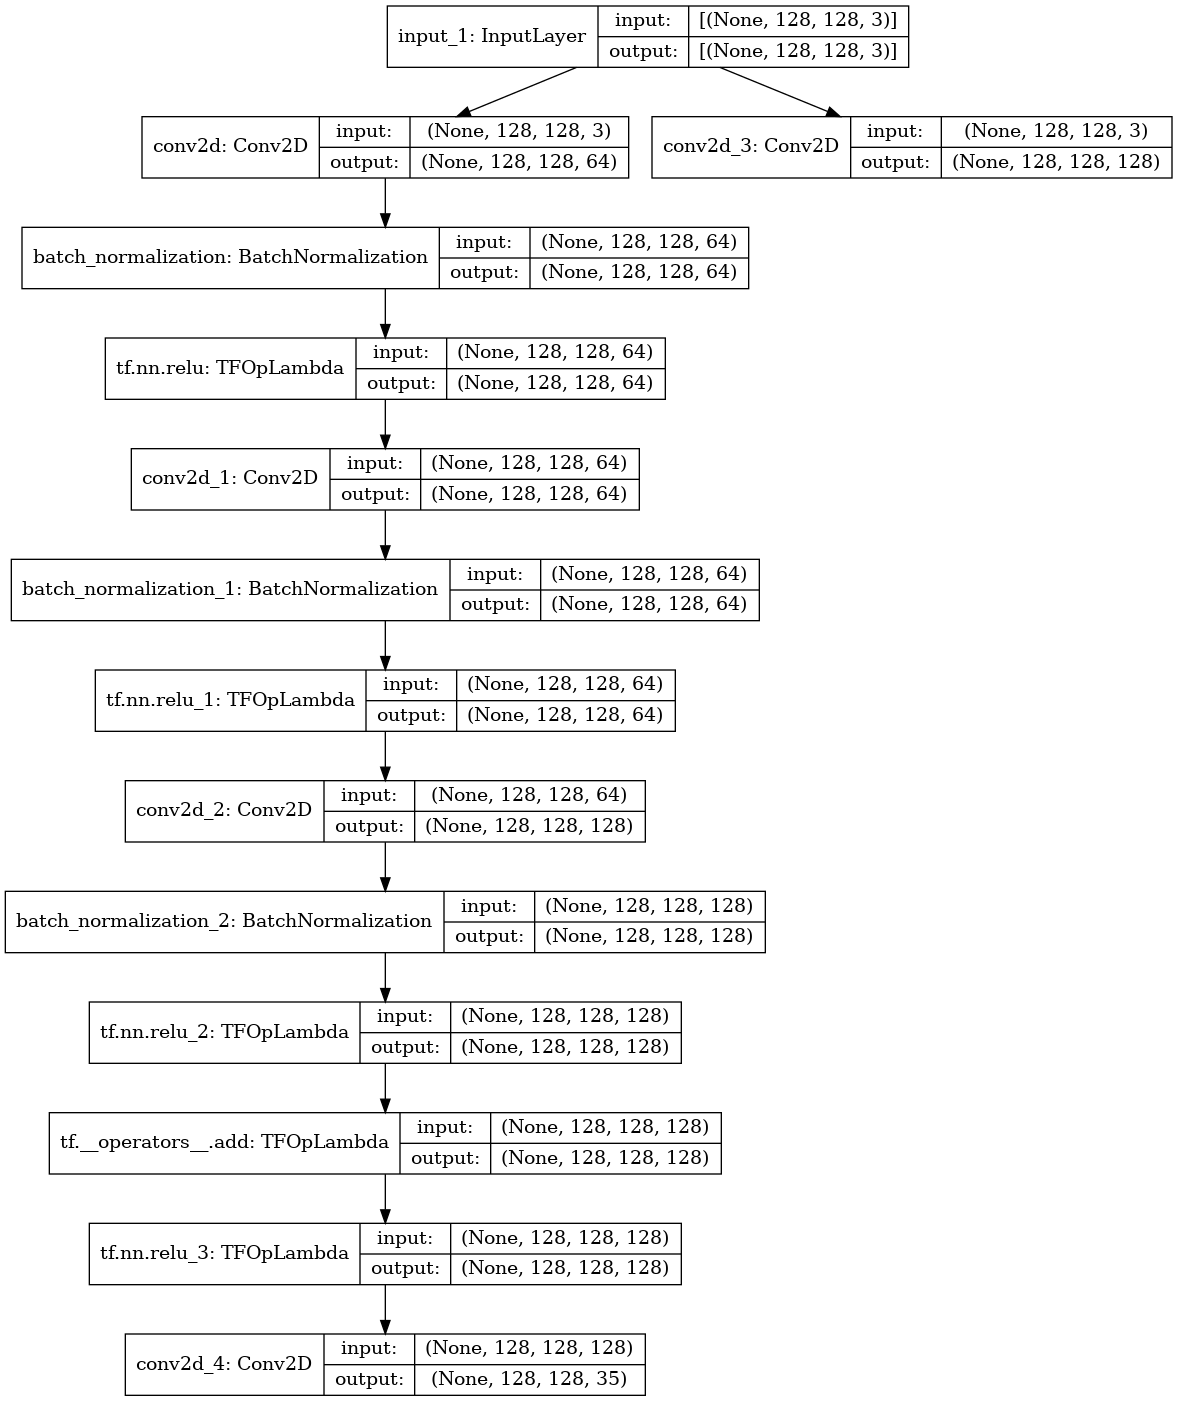

In [29]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [31]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.005),
    loss = loss,
    metrics = ['accuracy', UpdatedMeanIoU(num_classes=classes, name = "mean_iou")],
)

In [32]:
MODEL_CHECKPOINT_FILEPATH = './cityscapes-Hr-net.ckpt'
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                       monitor ='val_accuracy',
                       save_best_only = True,
                       save_weights_only = True,
                       verbose = 1,
                       mode = 'max'
                  )
callbacks = [model_checkpoint]

In [33]:
history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = 16,
                    epochs = 10,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = callbacks)

Epoch 1/10
186/186 [==============================] - 332s 2s/step - loss: 1.6497 - accuracy: 0.5262 - mean_iou: 0.0631 - val_loss: 2.5696 - val_accuracy: 0.3321 - val_mean_iou: 0.0128

Epoch 00001: val_accuracy improved from -inf to 0.33208, saving model to ./cityscapes-Hr-net.ckpt
Epoch 2/10
186/186 [==============================] - 328s 2s/step - loss: 1.4790 - accuracy: 0.5732 - mean_iou: 0.0935 - val_loss: 2.1910 - val_accuracy: 0.3985 - val_mean_iou: 0.0257

Epoch 00002: val_accuracy improved from 0.33208 to 0.39851, saving model to ./cityscapes-Hr-net.ckpt
Epoch 3/10
186/186 [==============================] - 324s 2s/step - loss: 1.4373 - accuracy: 0.5830 - mean_iou: 0.1000 - val_loss: 1.7236 - val_accuracy: 0.5003 - val_mean_iou: 0.0499

Epoch 00003: val_accuracy improved from 0.39851 to 0.50032, saving model to ./cityscapes-Hr-net.ckpt
Epoch 4/10
186/186 [==============================] - 322s 2s/step - loss: 1.4196 - accuracy: 0.5877 - mean_iou: 0.1035 - val_loss: 1.7667 - v

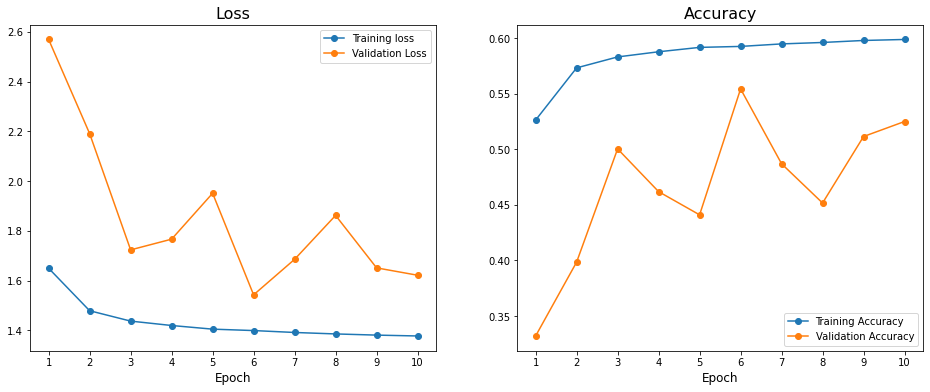

In [34]:
EPOCHS = 10
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [42]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) # load the best model weights
val_loss, val_accuracy = model.evaluate(x=val_images, y=val_masks_enc) # re-evaluate on the validation data
print('The model had an accuracy score of ' + str(format(round(100*val_accuracy, 2))))

15/15 [==============================] - 13s 866ms/step - loss: 1.5428 - accuracy: 0.5543 - mean_iou: 0.0966


ValueError: too many values to unpack (expected 2)

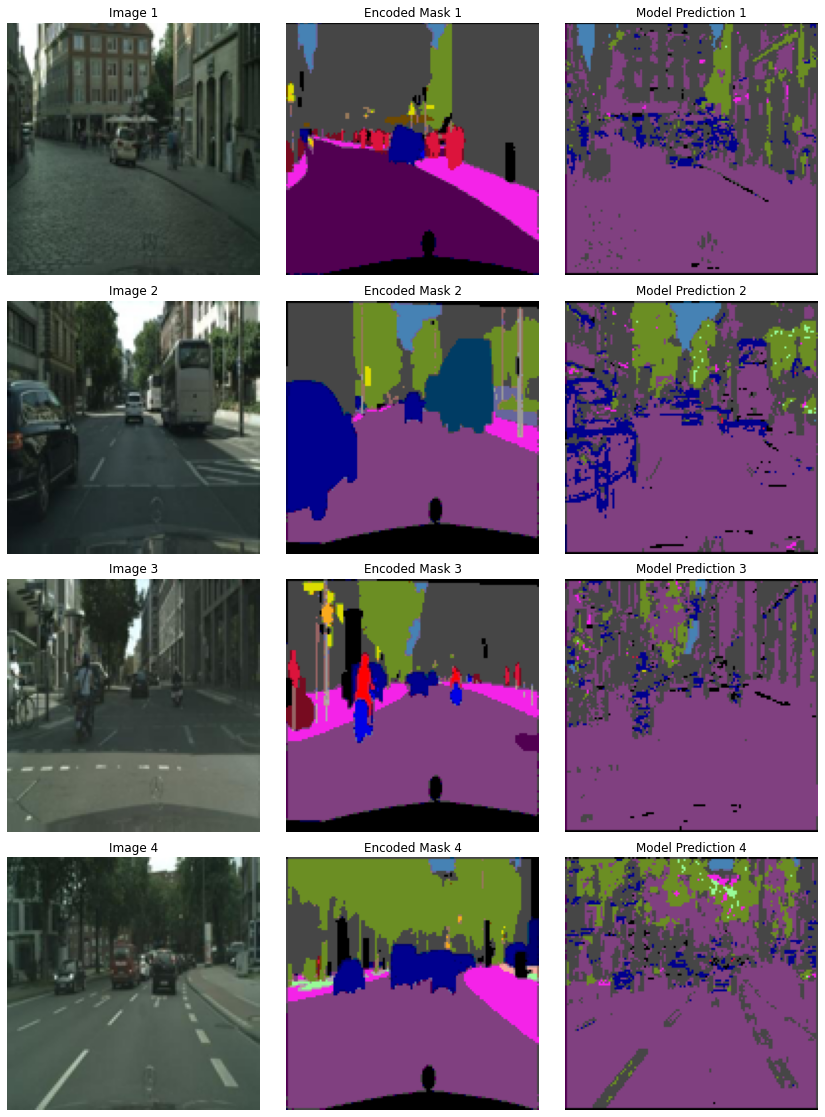

In [43]:
plt.figure(figsize=[15, 20])
IMAGE_SHAPE = IMAGE_SIZE + [3,]

for i in range(4):    
    img = val_images[i]
    enc = val_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [46]:
model.save("9c_highLoss.h5")